# A Diffusion Decision Model for Language-based Decisions

<img src="images/ddm_desc.jpeg" width="600">

Here, we use the `hddm` (Python) library$^1$ to model language-based decision making based on response-time & accuracy data from a binary forced-choice decision task. During each trial, subjects were presented with a digital image of an item (visual stimulus) and a verbal description (auditory stimulus). At the end of each trial, subjects were asked to indicate whether the two types of stimuli agreed (i.e. visual and auditory stimulus pointed to the same object) or were different (i.e. non-matching sound and image). Auditory and visual stimuli pairs fell under four distinct categories, as summarised below:  
- Condition 1 (**SS**): Same stimuli (see cat / hear cat)
- Condition 2 (**CP**): Phonologically congruent (see cat / hear hat)
- Condition 3 (**CS**): Semantically congruent (see cat / hear dog)
- Condition 4 (**US**): Unrelated stimuli (see house / hear cat)

In [1]:
# Environment setup
%matplotlib inline
%cd /lang_dec
# Imports
import warnings; warnings.filterwarnings('ignore')
import hddm
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bayesian_bootstrap.bootstrap as bootstrap
from utils import model_tools, signal_detection

/Users/celefthe/Programming/projects/language_decision


In [2]:
# Import pilot models
pilot_data = hddm.load_csv('/lang_dec/data/pilot_clean.csv')
pilot_model = hddm.HDDM(pilot_data, depends_on={'v': 'stim'}, bias=True)
pilot_model.load_db(dbname='language_decision/models/pilot', db='txt')

pilot_model_lumped = hddm.HDDM(pilot_data)
pilot_model_lumped.load_db(dbname='language_decision/models/pilot_lumped', db='txt')

#pilot_model_threshold = hddm.HDDM(pilot_data, depends_on={'v': 'stim', 'a': 'stim'})
#pilot_model_threshold.load_db(dbname='language_decision/models/pilot_threshold', db='txt')

In [3]:
# Import control models
controls_data = hddm.load_csv('/lang_dec/data/controls_clean.csv')
controls_model = hddm.HDDM(controls_data, depends_on={'v': 'stim'}, bias=True)
controls_model.load_db(dbname='language_decision/models/controls', db='txt')

controls_model_lumped = hddm.HDDM(controls_data)
controls_model_lumped.load_db(dbname='language_decision/models/controls_lumped', db='txt')

#controls_model_threshold = hddm.HDDM(controls_data, depends_on={'v': 'stim', 'a': 'stim'})
#controls_model_threshold.load_db(dbname='language_decision/models/controls_threshold', db='txt')

In [4]:
# Import patient models
patients_data = hddm.load_csv('/lang_dec/data/patients_clean.csv')
patients_model = hddm.HDDM(patients_data, depends_on={'v': 'stim'}, bias=True)
patients_model.load_db(dbname='language_decision/models/patients', db='txt')

patients_model_lumped = hddm.HDDM(patients_data)
patients_model_lumped.load_db(dbname='language_decision/models/patients_lumped', db='txt')

#patients_model_threshold = hddm.HDDM(patients_data, depends_on={'v': 'stim', 'a': 'stim'})
#patients_model_threshold.load_db(dbname='language_decision/models/patients_threshold', db='txt')

In [5]:
# Bootstrap function
def bayes_bootstrap(observed, stat_function, replications, resample_size):
    data_bs = bootstrap.bayesian_bootstrap(
        list(filter(None, observed)), stat_function, replications, resample_size)
    return {
        'bootstrap_data': data_bs,
        'central_tendency': {
            str(stat_function.__name__): stat_function(data_bs)
        },
        'CIs': {
            'high':  scipy.stats.mstats.mquantiles(data_bs, prob=[0.975])[0],
            'low': scipy.stats.mstats.mquantiles(data_bs, prob=[0.025])[0]
        } if stat_function.__name__ == 'median' else {
            'high':  stat_function(data_bs) + (1.96 * scipy.std(data_bs)),
            'low': stat_function(data_bs) - (1.96 * scipy.std(data_bs))
        }
    }

In [52]:
# Bootstrap comparison function
def compare_bootstrap_medians(sample1, sample2):
    median_diffs = [x - y for x in sample1 for y in sample2]
    return {
        'median_diffs': median_diffs,
        'central_tendency': scipy.median(median_diffs),
        'CIs': {
            'high':  scipy.stats.mstats.mquantiles(median_diffs, prob=[0.975])[0],
            'low': scipy.stats.mstats.mquantiles(median_diffs, prob=[0.025])[0]
        }
    }

## Performance Comparison

In [6]:
# Gather data

pilot_us = pilot_data.loc[pilot_data['stim'] == 'US']
pilot_ss = pilot_data.loc[pilot_data['stim'] == 'SS']
pilot_cp = pilot_data.loc[pilot_data['stim'] == 'CP']
pilot_cs = pilot_data.loc[pilot_data['stim'] == 'CS']

controls_us = controls_data.loc[controls_data['stim'] == 'US']
controls_ss = controls_data.loc[controls_data['stim'] == 'SS']
controls_cp = controls_data.loc[controls_data['stim'] == 'CP']
controls_cs = controls_data.loc[controls_data['stim'] == 'CS']

patients_us = patients_data.loc[patients_data['stim'] == 'US']
patients_ss = patients_data.loc[patients_data['stim'] == 'SS']
patients_cp = patients_data.loc[patients_data['stim'] == 'CP']
patients_cs = patients_data.loc[patients_data['stim'] == 'CS']

### Reaction Time

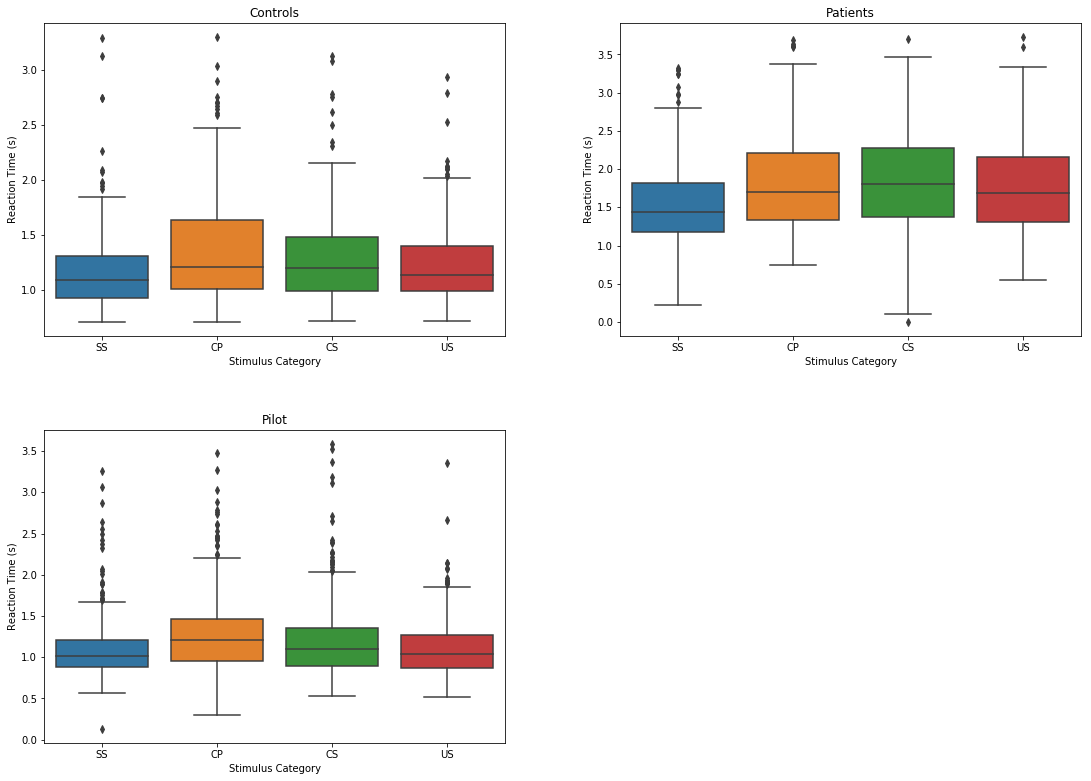

In [7]:
plt.figure(1)

plt.subplot(221)
box_rt_ctrl = sns.boxplot(
    data=[controls_ss.rt.values, controls_cp.rt.values, 
          controls_cs.rt.values, controls_us.rt.values])
box_rt_ctrl.set_xticklabels(['SS','CP','CS', 'US'])
box_rt_ctrl.set_xlabel("Stimulus Category")
box_rt_ctrl.set_ylabel("Reaction Time (s)")
box_rt_ctrl.set_title("Controls")

plt.subplot(222)
box_rt_ptns = sns.boxplot(
    data=[patients_ss.rt.values, patients_cp.rt.values, 
          patients_cs.rt.values, patients_us.rt.values])
box_rt_ptns.set_xticklabels(['SS','CP','CS', 'US'])
box_rt_ptns.set_xlabel("Stimulus Category")
box_rt_ptns.set_ylabel("Reaction Time (s)")
box_rt_ptns.set_title("Patients")

plt.subplot(223)
box_rt_plt = sns.boxplot(
    data=[pilot_ss.rt.values, pilot_cp.rt.values, 
          pilot_cs.rt.values, pilot_us.rt.values])
box_rt_plt.set_xticklabels(['SS','CP','CS', 'US'])
box_rt_plt.set_xlabel("Stimulus Category")
box_rt_plt.set_ylabel("Reaction Time (s)")
box_rt_plt.set_title("Pilot")

plt.subplots_adjust(top=2.5, bottom=0.001, left=0.10, right=2.5, hspace=0.30,
                    wspace=0.25)
plt.show()

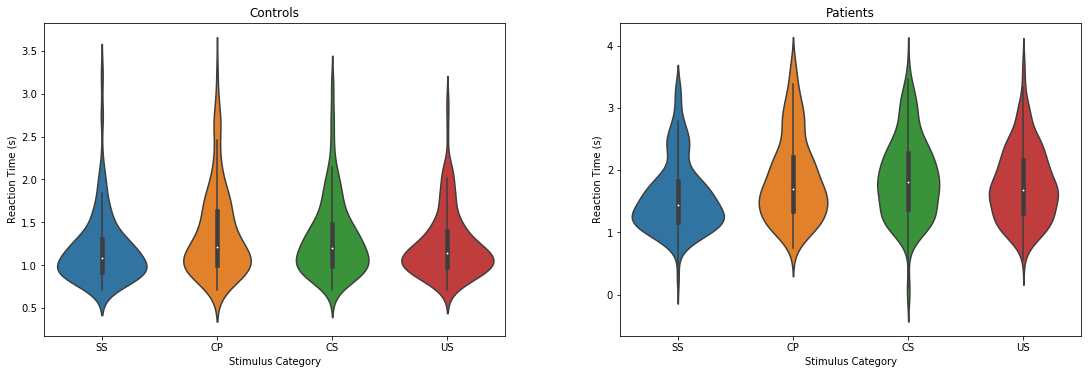

In [246]:
## Controls vs Patients
plt.figure(1)

plt.subplot(221)
vp_rt_ctrl = sns.violinplot(
    data=[controls_ss.rt.values, controls_cp.rt.values, 
          controls_cs.rt.values, controls_us.rt.values], 
    inner='box')
vp_rt_ctrl.set_xticklabels(['SS','CP','CS', 'US'])
vp_rt_ctrl.set_xlabel("Stimulus Category")
vp_rt_ctrl.set_ylabel("Reaction Time (s)")
vp_rt_ctrl.set_title("Controls")

plt.subplot(222)
vp_rt_ptns = sns.violinplot(
    data=[patients_ss.rt.values, patients_cp.rt.values, 
          patients_cs.rt.values, patients_us.rt.values], 
    inner='box')
vp_rt_ptns.set_xticklabels(['SS','CP','CS', 'US'])
vp_rt_ptns.set_xlabel("Stimulus Category")
vp_rt_ptns.set_ylabel("Reaction Time (s)")
vp_rt_ptns.set_title("Patients")

plt.subplots_adjust(top=2.5, bottom=0.001, left=0.10, right=2.5, hspace=0.30,
                    wspace=0.25)

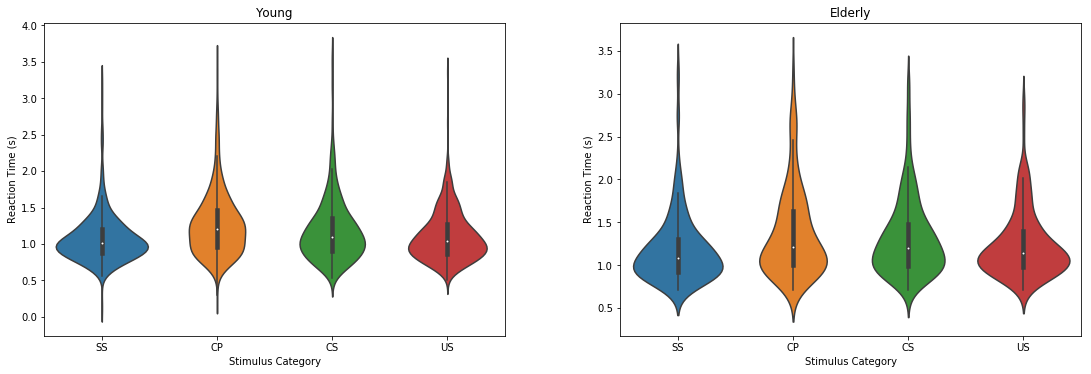

In [245]:
## Young (pilot) vs Elderly (controls)
plt.figure(1)

plt.subplot(221)
vp_rt_plt = sns.violinplot(
    data=[pilot_ss.rt.values, pilot_cp.rt.values, pilot_cs.rt.values, pilot_us.rt.values], 
    inner='box')
vp_rt_plt.set_xticklabels(['SS','CP','CS', 'US'])
vp_rt_plt.set_xlabel("Stimulus Category")
vp_rt_plt.set_ylabel("Reaction Time (s)")
vp_rt_plt.set_title("Young")


plt.subplot(222)
vp_rt_ctrl = sns.violinplot(
    data=[controls_ss.rt.values, controls_cp.rt.values, 
          controls_cs.rt.values, controls_us.rt.values], 
    inner='box')
vp_rt_ctrl.set_xticklabels(['SS','CP','CS', 'US'])
vp_rt_ctrl.set_xlabel("Stimulus Category")
vp_rt_ctrl.set_ylabel("Reaction Time (s)")
vp_rt_ctrl.set_title("Elderly")

plt.subplots_adjust(top=2.5, bottom=0.001, left=0.10, right=2.5, hspace=0.30,
                    wspace=0.25)

#### Bootstrap Median Differences Between Subject Groups

In [165]:
rt_comps = dict()

##### Pilot vs Controls

In [247]:
subj_group = 'pilot_controls'
stim_group = 'ss'
rt_comps[subj_group] = dict()
diffs = [y - x for x in pilot_ss.rt.values for y in controls_ss.rt.values]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))


#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.07597441443340347, 'low': 0.067245924265985232}
{'median': 0.07181416863363671}


In [248]:
subj_group = 'pilot_controls'
stim_group = 'cs'
rt_comps[subj_group] = dict()
diffs = [y - x for x in pilot_ss.rt.values for y in controls_ss.rt.values]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))


#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.076068599968098213, 'low': 0.067297576639812132}
{'median': 0.071835865885986894}


In [249]:
subj_group = 'pilot_controls'
stim_group = 'cp'
rt_comps[subj_group] = dict()
diffs = [y - x for x in pilot_ss.rt.values for y in controls_ss.rt.values]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))


#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.075664460255929961, 'low': 0.067214263739303989}
{'median': 0.071639963613051805}


In [250]:
subj_group = 'pilot_controls'
stim_group = 'us'
rt_comps[subj_group] = dict()
diffs = [y - x for x in pilot_ss.rt.values for y in controls_ss.rt.values]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))


#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.076262769107965922, 'low': 0.067109744949598343}
{'median': 0.071555668293513008}


##### Controls vs Patients

In [251]:
subj_group = 'controls_patients'
stim_group = 'ss'
rt_comps[subj_group] = dict()
diffs = [y - x for x in controls_ss.rt.values for y in patients_ss.rt.values]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.33709220670601103, 'low': 0.32052888706966987}
{'median': 0.32885676215209952}


In [252]:
subj_group = 'controls_patients'
stim_group = 'cs'
rt_comps[subj_group] = dict()
diffs = [y - x for x in controls_cs.rt.values for y in patients_cs.rt.values]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.55441644398338874, 'low': 0.52755510798758687}
{'median': 0.54092362479241263}


In [253]:
subj_group = 'controls_patients'
stim_group = 'cp'
rt_comps[subj_group] = dict()
diffs = [y - x for x in controls_cp.rt.values for y in patients_cp.rt.values]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.4499891906535845, 'low': 0.4236979418058513}
{'median': 0.43753749169309231}


In [254]:
subj_group = 'controls_patients'
stim_group = 'us'
rt_comps[subj_group] = dict()
diffs = [y - x for x in controls_us.rt.values for y in patients_us.rt.values]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.52246497434998318, 'low': 0.49825381742713942}
{'median': 0.51060115561449493}


#### Bootstrap Median Differences Between Stimuli Groups (Incogruency Effect Only)

##### Pilot

In [255]:
subj_group = 'pilot'
stim_group = 'ss_us'
rt_comps[subj_group] = dict()
diffs = [y - x for x in pilot_ss.rt.values for y in pilot_us.rt.values]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.027342260543766705, 'low': 0.022223591121406931}
{'median': 0.024885874650863116}


In [256]:
subj_group = 'pilot'
stim_group = 'ss_cs'
rt_comps[subj_group] = dict()
diffs = [y - x for x in pilot_ss.rt.values for y in pilot_cs.rt.values]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.079665378385777849, 'low': 0.073890028210979605}
{'median': 0.076709649392114443}


In [257]:
subj_group = 'pilot'
stim_group = 'ss_cp'
rt_comps[subj_group] = dict()
diffs = [y - x for x in pilot_ss.rt.values for y in pilot_cp.rt.values]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.16711698630972077, 'low': 0.16046190483401002}
{'median': 0.1638456729598943}


##### Controls

In [258]:
subj_group = 'controls'
stim_group = 'ss_us'
rt_comps[subj_group] = dict()
diffs = [y - x for x in controls_ss.rt.values for y in controls_us.rt.values]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.063017504363601776, 'low': 0.048057114543671606}
{'median': 0.055515654996725061}


In [259]:
subj_group = 'controls'
stim_group = 'ss_cs'
rt_comps[subj_group] = dict()
diffs = [y - x for x in controls_ss.rt.values for y in controls_cs.rt.values]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.11622758761325488, 'low': 0.099280618591819747}
{'median': 0.10799556346955794}


In [260]:
subj_group = 'controls'
stim_group = 'ss_cp'
rt_comps[subj_group] = dict()
diffs = [y - x for x in controls_ss.rt.values for y in controls_cp.rt.values]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.13026297314024776, 'low': 0.11290449573516526}
{'median': 0.12193435888730164}


##### Patients

In [261]:
subj_group = 'patients'
stim_group = 'ss_us'
rt_comps[subj_group] = dict()
diffs = [y - x for x in patients_ss.rt.values for y in patients_us.rt.values]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.21930599220998137, 'low': 0.19599451971044335}
{'median': 0.20792219633699477}


In [262]:
subj_group = 'patients'
stim_group = 'ss_cs'
rt_comps[subj_group] = dict()
diffs = [y - x for x in patients_ss.rt.values for y in patients_cs.rt.values]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.3189139529623119, 'low': 0.29635593112248898}
{'median': 0.30762908478641293}


In [263]:
subj_group = 'patients'
stim_group = 'ss_cp'
rt_comps[subj_group] = dict()
diffs = [y - x for x in patients_ss.rt.values for y in patients_cp.rt.values]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.25781649037549642, 'low': 0.23487164877892849}
{'median': 0.24651901775473545}


### Accuracy

In [9]:
def get_accuracies(subjects):
    accuracies = []
    grouped_subjects = subjects.groupby('subj_idx')
    for subject in [grouped_subjects.get_group(x) for x in grouped_subjects.groups]:
        accuracies.append(len([x for x in subject.response.values if x >= 1]) / len(subject.response.values))
    return accuracies

In [10]:
pilot_ss_accuracies = get_accuracies(pilot_ss)
pilot_cp_accuracies = get_accuracies(pilot_cp)
pilot_cs_accuracies = get_accuracies(pilot_cs)
pilot_us_accuracies = get_accuracies(pilot_us)

controls_ss_accuracies = get_accuracies(controls_ss)
controls_cp_accuracies = get_accuracies(controls_cp)
controls_cs_accuracies = get_accuracies(controls_cs)
controls_us_accuracies = get_accuracies(controls_us)

patients_ss_accuracies = get_accuracies(patients_ss) 
patients_cp_accuracies = get_accuracies(patients_cp)
patients_cs_accuracies = get_accuracies(patients_cs)
patients_us_accuracies = get_accuracies(patients_us)

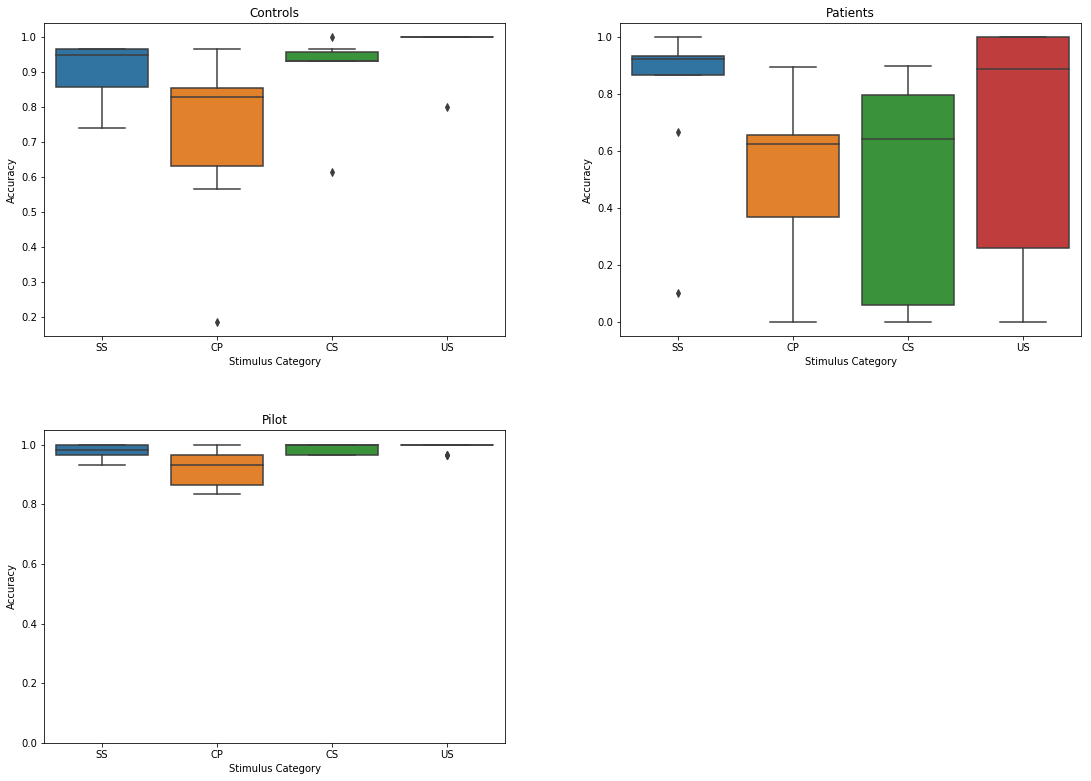

In [11]:
plt.figure(1)

plt.subplot(221)
box_acc_ctrl = sns.boxplot(
    data=[controls_ss_accuracies, controls_cp_accuracies, 
          controls_cs_accuracies, controls_us_accuracies])
box_acc_ctrl.set_xticklabels(['SS','CP','CS', 'US'])
box_acc_ctrl.set_xlabel("Stimulus Category")
box_acc_ctrl.set_ylabel("Accuracy")
box_acc_ctrl.set_title("Controls")

plt.subplot(222)
box_acc_ptns = sns.boxplot(
    data=[patients_ss_accuracies, patients_cp_accuracies, 
          patients_cs_accuracies, patients_us_accuracies])
box_acc_ptns.set_xticklabels(['SS','CP','CS', 'US'])
box_acc_ptns.set_xlabel("Stimulus Category")
box_acc_ptns.set_ylabel("Accuracy")
box_acc_ptns.set_title("Patients")

plt.subplot(223)
box_acc_plt = sns.boxplot(
    data=[pilot_ss_accuracies, pilot_cp_accuracies, pilot_cs_accuracies, pilot_us_accuracies])
box_acc_plt.set_xticklabels(['SS','CP','CS', 'US'])
box_acc_plt.set_xlabel("Stimulus Category")
box_acc_plt.set_ylabel("Accuracy")
box_acc_plt.set_title("Pilot")

plt.subplots_adjust(top=2.5, bottom=0.001, left=0.10, right=2.5, hspace=0.30,
                    wspace=0.25)
plt.ylim(0, 1.05)
plt.show()

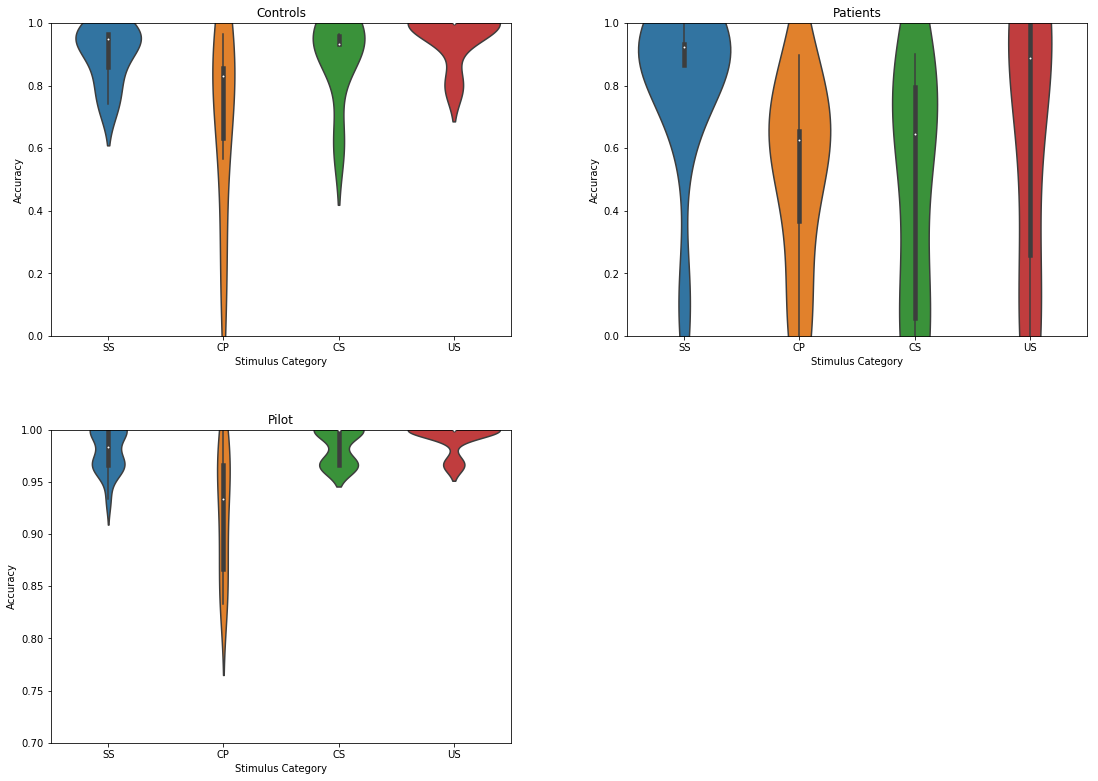

In [12]:
plt.figure(1)

plt.subplot(221)
vp_acc_ctrl = sns.violinplot(
    data=[controls_ss_accuracies, controls_cp_accuracies, 
          controls_cs_accuracies, controls_us_accuracies], 
    inner='box')
vp_acc_ctrl.set_xticklabels(['SS','CP','CS', 'US'])
vp_acc_ctrl.set_xlabel("Stimulus Category")
vp_acc_ctrl.set_ylabel("Accuracy")
vp_acc_ctrl.set_title("Controls")
vp_acc_ctrl.set_ylim(0,1)

plt.subplot(222)
vp_acc_ptns = sns.violinplot(
    data=[patients_ss_accuracies, patients_cp_accuracies, 
          patients_cs_accuracies, patients_us_accuracies], 
    inner='box')
vp_acc_ptns.set_xticklabels(['SS','CP','CS', 'US'])
vp_acc_ptns.set_xlabel("Stimulus Category")
vp_acc_ptns.set_ylabel("Accuracy")
vp_acc_ptns.set_title("Patients")
vp_acc_ptns.set_ylim(0,1)

plt.subplot(223)
vp_acc_plt = sns.violinplot(
    data=[pilot_ss_accuracies, pilot_cp_accuracies, pilot_cs_accuracies, pilot_us_accuracies], 
    inner='box')
vp_acc_plt.set_xticklabels(['SS','CP','CS', 'US'])
vp_acc_plt.set_xlabel("Stimulus Category")
vp_acc_plt.set_ylabel("Accuracy")
vp_acc_plt.set_title("Pilot")
vp_acc_plt.set_ylim(0.7, 1)

plt.subplots_adjust(top=2.5, bottom=0.001, left=0.10, right=2.5, hspace=0.30,
                    wspace=0.25)

#### Bootstrap Median Differences Between Subject Groups

In [196]:
acc_comps = dict()

##### Pilot vs Controls

In [264]:
subj_group = 'pilot_controls'
stim_group = 'ss'
rt_comps[subj_group] = dict()
diffs = [x - y for x in pilot_ss_accuracies for y in controls_ss_accuracies]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.1333333333333333, 'low': 0.033333333333333326}
{'median': 0.066666666666666652}


In [265]:
subj_group = 'pilot_controls'
stim_group = 'cs'
rt_comps[subj_group] = dict()
diffs = [x - y for x in pilot_cs_accuracies for y in controls_cs_accuracies]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.066666666666666652, 'low': 0.034482758620689613}
{'median': 0.058908045977011492}


In [266]:
subj_group = 'pilot_controls'
stim_group = 'cp'
rt_comps[subj_group] = dict()
diffs = [x - y for x in pilot_cp_accuracies for y in controls_cp_accuracies]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.26666666666666672, 'low': 0.099999999999999978}
{'median': 0.1333333333333333}


In [267]:
subj_group = 'pilot_controls'
stim_group = 'us'
rt_comps[subj_group] = dict()
diffs = [x - y for x in pilot_us_accuracies for y in controls_us_accuracies]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.19999999999999996, 'low': -0.033333333333333326}
{'median': 0.16666666666666663}


##### Controls vs Patients

In [268]:
subj_group = 'controls_patients'
stim_group = 'ss'
rt_comps[subj_group] = dict()
diffs = [y - x for x in patients_ss_accuracies for y in controls_ss_accuracies]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.070370370370370361, 'low': -0.033333333333333326}
{'median': 0.033333333333333326}


In [269]:
subj_group = 'controls_patients'
stim_group = 'cs'
rt_comps[subj_group] = dict()
diffs = [y - x for x in patients_cs_accuracies for y in controls_cs_accuracies]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.69770114942528738, 'low': 0.16666666666666663}
{'median': 0.30000000000000004}


In [270]:
subj_group = 'controls_patients'
stim_group = 'cp'
rt_comps[subj_group] = dict()
diffs = [y - x for x in patients_cp_accuracies for y in controls_cp_accuracies]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.31282051282051282, 'low': 0.065982758620689627}
{'median': 0.19999999999999996}


In [271]:
subj_group = 'controls_patients'
stim_group = 'us'
rt_comps[subj_group] = dict()
diffs = [y - x for x in patients_us_accuracies for y in controls_us_accuracies]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.83333333333333337, 'low': 0.19047619047619047}
{'median': 0.46666666666666667}


#### Bootstrap Median Differences Between Stimuli Categories (Within Subject Groups, Incogruency Only) 

##### Pilot

In [272]:
subj_group = 'pilot'
stim_group = 'ss_us'
rt_comps[subj_group] = dict()
diffs = [x - y for x in pilot_ss_accuracies for y in pilot_us_accuracies]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': -0.033333333333333326, 'low': -0.033333333333333326}
{'median': -0.033333333333333326}


In [273]:
subj_group = 'pilot'
stim_group = 'ss_cs'
rt_comps[subj_group] = dict()
diffs = [x - y for x in pilot_ss_accuracies for y in pilot_cs_accuracies]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.0011494252873562871, 'low': -0.033333333333333326}
{'median': -0.033333333333333326}


In [274]:
subj_group = 'pilot'
stim_group = 'ss_cp'
rt_comps[subj_group] = dict()
diffs = [x - y for x in pilot_ss_accuracies for y in pilot_cp_accuracies]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.099999999999999978, 'low': 0.066666666666666652}
{'median': 0.066666666666666652}


##### Controls

In [275]:
subj_group = 'controls'
stim_group = 'ss_us'
rt_comps[subj_group] = dict()
diffs = [x - y for x in controls_ss_accuracies for y in controls_us_accuracies]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': -0.033333333333333326, 'low': -0.11666666666666664}
{'median': -0.033333333333333326}


In [276]:
subj_group = 'controls'
stim_group = 'ss_cs'
rt_comps[subj_group] = dict()
diffs = [x - y for x in controls_ss_accuracies for y in controls_cs_accuracies]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.034482758620689669, 'low': -0.082183908045976972}
{'median': 0.0011494252873562871}


In [277]:
subj_group = 'controls'
stim_group = 'ss_cp'
rt_comps[subj_group] = dict()
diffs = [x - y for x in controls_ss_accuracies for y in controls_cp_accuracies]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.3666666666666667, 'low': 0.077083333333333393}
{'median': 0.1333333333333333}


##### Patients

In [278]:
subj_group = 'patients'
stim_group = 'ss_us'
rt_comps[subj_group] = dict()
diffs = [x - y for x in patients_ss_accuracies for y in patients_us_accuracies]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.23889102564102593, 'low': -0.066666666666666652}
{'median': -0.012179487179487164}


In [279]:
stim_group = 'ss_cs'
rt_comps[subj_group] = dict()
diffs = [x - y for x in patients_ss_accuracies for y in patients_cs_accuracies]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.41983333333333422, 'low': 0.125747150997151}
{'median': 0.25530852994555353}


In [280]:
stim_group = 'ss_cp'
rt_comps[subj_group] = dict()
diffs = [x - y for x in patients_ss_accuracies for y in patients_cp_accuracies]

rt_comps[subj_group][stim_group] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(rt_comps[subj_group][stim_group]['bootstrap_data'])
print(rt_comps[subj_group][stim_group]['CIs'])
print(rt_comps[subj_group][stim_group]['central_tendency'])

{'high': 0.34549071618037136, 'low': 0.21282051282051284}
{'median': 0.28045977011494261}


### Signal Detection Theory & d'

**Hit:** SS + "same" response  
**False Alarm:** US/CS/CP + "same" response

**Miss:** SS + "diff" response  
**Correct Rejection:** US/CS/CP + "diff" response

**Stim Group 1**: SS  
**Stim Group 2**: US / CS / CP

In [13]:
def get_d_primes(dataset, stim1, stim2, include_id=False):
    d_primes = dict()
    subject_ids = set(dataset.subj_idx)
    for subject_id in subject_ids:
        stim1_data = dataset.loc[
            dataset['subj_idx'] == subject_id].loc[
            dataset['stim'] == str(stim1)]
        stim1_trials = len(stim1_data)
        hits = len(stim1_data.loc[
            dataset['response'] == 1.0])
        
        stim2_data = dataset.loc[
            dataset['subj_idx'] == subject_id].loc[
            dataset['stim'] == str(stim2)]
        stim2_trials = len(stim2_data)
        
        fas = len(stim2_data.loc[
            dataset['response'] == 0.0])
        
        if not stim1_trials or not stim2_trials:
            d_primes[subject_id] = None # N/A placeholder value
            continue
        
        d_prime = signal_detection.signal_detection(
            n_stim1=stim1_trials, 
            n_stim2=stim2_trials, 
            hits=hits, 
            false_alarms=fas)['d_prime']
        d_primes[subject_id] = d_prime
       
    if not include_id:
        return list(d_primes.values())
    return d_primes

In [14]:
## Pilot d'
pilot_dprimes = {
    'ss_us': get_d_primes(pilot_data, 'SS', 'US'),
    'ss_cs': get_d_primes(pilot_data, 'SS', 'CS'),
    'ss_cp': get_d_primes(pilot_data, 'SS', 'CP')
}

## Controls d'
controls_dprimes = {
    'ss_us': get_d_primes(controls_data, 'SS', 'US'),
    'ss_cs': get_d_primes(controls_data, 'SS', 'CS'),
    'ss_cp': get_d_primes(controls_data, 'SS', 'CP')
}

## Patients d'
patients_dprimes = {
    'ss_us': get_d_primes(patients_data, 'SS', 'US'),
    'ss_cs': get_d_primes(patients_data, 'SS', 'CS'),
    'ss_cp': get_d_primes(patients_data, 'SS', 'CP')
}

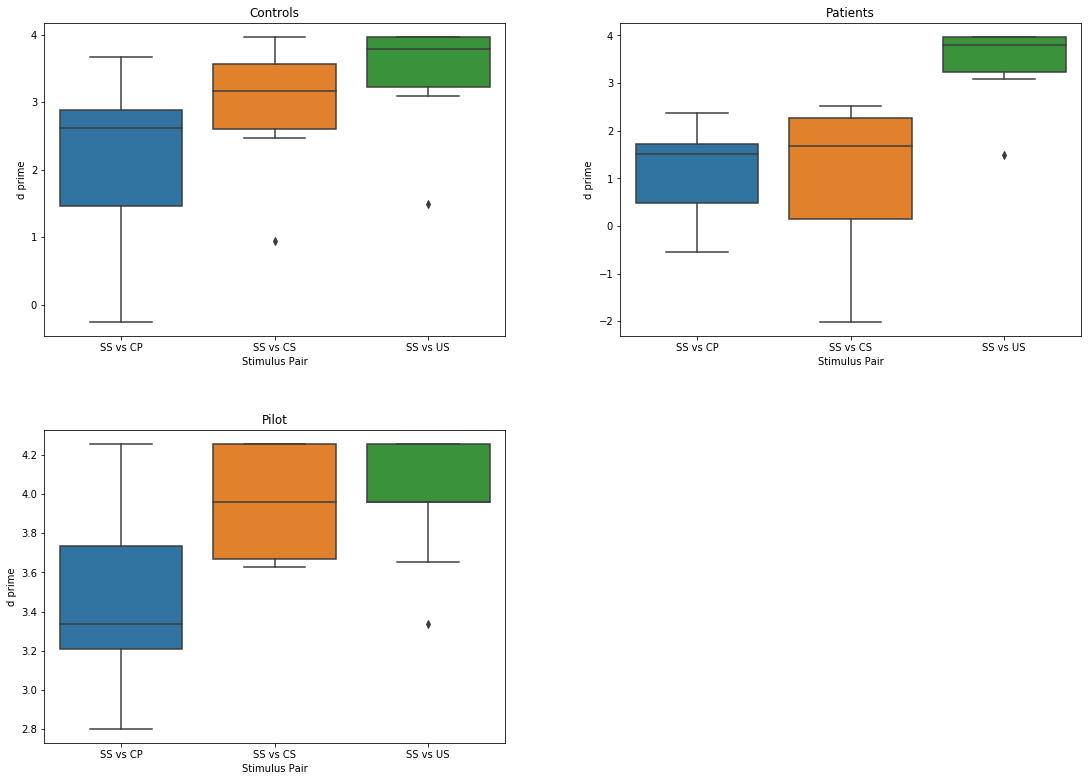

In [15]:
## Plotting d's
plt.figure(1)

plt.subplot(221)
box_dprime_ctrl = sns.boxplot(
    data=[controls_dprimes['ss_cp'],
          controls_dprimes['ss_cs'],
          controls_dprimes['ss_us']])
box_dprime_ctrl.set_xticklabels(['SS vs CP','SS vs CS', 'SS vs US'])
box_dprime_ctrl.set_xlabel("Stimulus Pair")
box_dprime_ctrl.set_ylabel("d prime")
box_dprime_ctrl.set_title("Controls")

plt.subplot(222)
box_dprime_ptns = sns.boxplot(
    data=[patients_dprimes['ss_cp'],
          patients_dprimes['ss_cs'],
          controls_dprimes['ss_us']])
box_dprime_ptns.set_xticklabels(['SS vs CP','SS vs CS', 'SS vs US'])
box_dprime_ptns.set_xlabel("Stimulus Pair")
box_dprime_ptns.set_ylabel("d prime")
box_dprime_ptns.set_title("Patients")

plt.subplot(223)
box_dprime_plt = sns.boxplot(
    data=[pilot_dprimes['ss_cp'],
          pilot_dprimes['ss_cs'],
          pilot_dprimes['ss_us']])
box_dprime_plt.set_xticklabels(['SS vs CP','SS vs CS', 'SS vs US'])
box_dprime_plt.set_xlabel("Stimulus Pair")
box_dprime_plt.set_ylabel("d prime")
box_dprime_plt.set_title("Pilot")

plt.subplots_adjust(top=2.5, bottom=0.001, left=0.10, right=2.5, hspace=0.30,
                    wspace=0.25)

#### Bootstrap Median Differences
http://faculty.psy.ohio-state.edu/myung/personal/course/826/bootstrap_hypo.pdf

In [73]:
## Pilot vs Controls d'
dp_pilot_controls = dict()

In [281]:
stim_key = 'ss_us'
diffs = [x - y for x in pilot_dprimes[stim_key] for y in controls_dprimes[stim_key]]
dp_pilot_controls[stim_key] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(dp_pilot_controls[stim_key]['bootstrap_data'])
print(dp_pilot_controls[stim_key]['CIs'])
print(dp_pilot_controls[stim_key]['central_tendency'])

{'high': 0.85966083838550134, 'low': 0.29413059836906852}
{'median': 0.33282868977188995}


In [282]:
stim_key = 'ss_cs'
diffs = [x - y for x in pilot_dprimes[stim_key] for y in controls_dprimes[stim_key]]
dp_pilot_controls[stim_key] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(dp_pilot_controls[stim_key]['bootstrap_data'])
print(dp_pilot_controls[stim_key]['CIs'])
print(dp_pilot_controls[stim_key]['central_tendency'])

{'high': 1.1993217594861032, 'low': 0.60353023970399189}
{'median': 0.92108988651002743}


In [283]:
stim_key = 'ss_cp'
diffs = [x - y for x in pilot_dprimes[stim_key] for y in controls_dprimes[stim_key]]
dp_pilot_controls[stim_key] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(dp_pilot_controls[stim_key]['bootstrap_data'])
print(dp_pilot_controls[stim_key]['CIs'])
print(dp_pilot_controls[stim_key]['central_tendency'])

{'high': 1.4934523578551717, 'low': 0.60761024243954798}
{'median': 0.91516716600264814}


In [138]:
## Controls vs Patients d'
dp_controls_patients = dict()

In [284]:
stim_key = 'ss_us'
diffs = [x - y for x in controls_dprimes[stim_key] for y in patients_dprimes[stim_key]]
dp_controls_patients[stim_key] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(dp_controls_patients[stim_key]['bootstrap_data'])
print(dp_controls_patients[stim_key]['CIs'])
print(dp_controls_patients[stim_key]['central_tendency'])

{'high': 2.2851785107659683, 'low': 0.62695928814095891}
{'median': 1.3266417617679784}


In [285]:
stim_key = 'ss_cs'
diffs = [x - y for x in controls_dprimes[stim_key] for y in patients_dprimes[stim_key]]
dp_controls_patients[stim_key] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(dp_controls_patients[stim_key]['bootstrap_data'])
print(dp_controls_patients[stim_key]['CIs'])
print(dp_controls_patients[stim_key]['central_tendency'])

{'high': 2.4313468697492651, 'low': 0.95841282815938955}
{'median': 1.5314282482738162}


In [286]:
stim_key = 'ss_cp'
diffs = [x - y for x in controls_dprimes[stim_key] 
         for y in list(filter(None, patients_dprimes[stim_key]))]
dp_controls_patients[stim_key] = bayes_bootstrap(diffs, scipy.median, 1000, len(diffs))

#plt.hist(dp_controls_patients[stim_key]['bootstrap_data'])
print(dp_controls_patients[stim_key]['CIs'])
print(dp_controls_patients[stim_key]['central_tendency'])

{'high': 1.7835690269572835, 'low': 0.55065982450242856}
{'median': 1.0769507361453772}


## Diffusion Decision Model Comparisons

### Drift Rate Between Stimuli Groups (Within Subjects)

Drift Rate Analysis: Pilot
P(v[SS] > v[US]) = 0.760795454545
P(v[SS] > v[CP]) = 1.0
P(v[SS] > v[CS]) = 0.998181818182
P(v[CP] > v[CS]) = 0.0
P(v[CP] > v[US]) = 0.0
P(v[CS] > v[US]) = 0.0110227272727


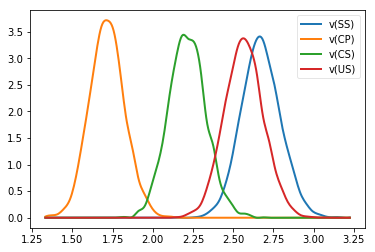

In [30]:
pilot_vSS, pilot_vCP, pilot_vCS, pilot_vUS = pilot_model.nodes_db.node[['v(SS)', 'v(CP)', 'v(CS)', 'v(US)']]

hddm.analyze.plot_posterior_nodes([pilot_vSS, pilot_vCP, pilot_vCS, pilot_vUS])

print("Drift Rate Analysis: Pilot")
print('P(v[SS] > v[US]) = ' + str((pilot_vSS.trace() > pilot_vUS.trace()).mean()))
print('P(v[SS] > v[CP]) = ' + str((pilot_vSS.trace() > pilot_vCP.trace()).mean()))
print('P(v[SS] > v[CS]) = ' + str((pilot_vSS.trace() > pilot_vCS.trace()).mean()))
print('P(v[CP] > v[CS]) = ' + str((pilot_vCP.trace() > pilot_vCS.trace()).mean()))
print('P(v[CP] > v[US]) = ' + str((pilot_vCP.trace() > pilot_vUS.trace()).mean()))
print('P(v[CS] > v[US]) = ' + str((pilot_vCS.trace() > pilot_vUS.trace()).mean()))

Drift Rate Analysis: Controls
P(v[SS] > v[US]) = 0.315
P(v[SS] > v[CP]) = 0.989431818182
P(v[SS] > v[CS]) = 0.800909090909
P(v[CP] > v[CS]) = 0.06125
P(v[CP] > v[US]) = 0.00511363636364
P(v[CS] > v[US]) = 0.0948863636364


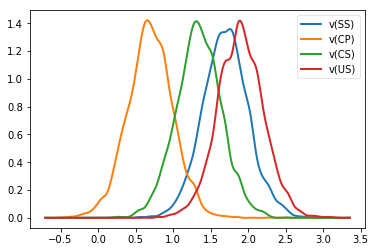

In [31]:
controls_vSS, controls_vCP, controls_vCS, controls_vUS = controls_model.nodes_db.node[['v(SS)', 'v(CP)', 'v(CS)', 'v(US)']]

hddm.analyze.plot_posterior_nodes([controls_vSS, controls_vCP, controls_vCS, controls_vUS])

print("Drift Rate Analysis: Controls")
print('P(v[SS] > v[US]) = ' + str((controls_vSS.trace() > controls_vUS.trace()).mean()))
print('P(v[SS] > v[CP]) = ' + str((controls_vSS.trace() > controls_vCP.trace()).mean()))
print('P(v[SS] > v[CS]) = ' + str((controls_vSS.trace() > controls_vCS.trace()).mean()))
print('P(v[CP] > v[CS]) = ' + str((controls_vCP.trace() > controls_vCS.trace()).mean()))
print('P(v[CP] > v[US]) = ' + str((controls_vCP.trace() > controls_vUS.trace()).mean()))
print('P(v[CS] > v[US]) = ' + str((controls_vCS.trace() > controls_vUS.trace()).mean()))

Drift Rate Analysis: Patients
P(v[SS] > v[US]) = 0.922045454545
P(v[SS] > v[CP]) = 0.983068181818
P(v[SS] > v[CS]) = 0.984659090909
P(v[CP] > v[CS]) = 0.486136363636
P(v[CP] > v[US]) = 0.205227272727
P(v[CS] > v[US]) = 0.209318181818


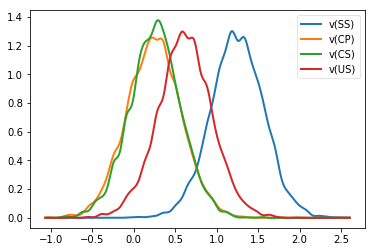

In [32]:
patients_vSS, patients_vCP, patients_vCS, patients_vUS = patients_model.nodes_db.node[['v(SS)', 'v(CP)', 'v(CS)', 'v(US)']]

hddm.analyze.plot_posterior_nodes([patients_vSS, patients_vCP, patients_vCS, patients_vUS])

print("Drift Rate Analysis: Patients")
print('P(v[SS] > v[US]) = ' + str((patients_vSS.trace() > patients_vUS.trace()).mean()))
print('P(v[SS] > v[CP]) = ' + str((patients_vSS.trace() > patients_vCP.trace()).mean()))
print('P(v[SS] > v[CS]) = ' + str((patients_vSS.trace() > patients_vCS.trace()).mean()))
print('P(v[CP] > v[CS]) = ' + str((patients_vCP.trace() > patients_vCS.trace()).mean()))
print('P(v[CP] > v[US]) = ' + str((patients_vCP.trace() > patients_vUS.trace()).mean()))
print('P(v[CS] > v[US]) = ' + str((patients_vCS.trace() > patients_vUS.trace()).mean()))

---

---

### Drift Rate Between Subjects & Stimuli Groups

Drift Rate Analysis: SS
P(patients_vSS > controls_vSS) = 0.145227272727
P(controls_vSS > pilot_vSS) = 0.00181818181818


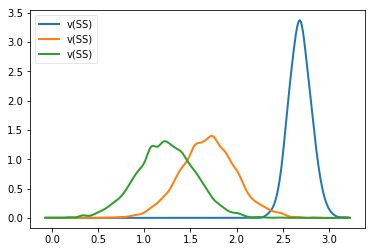

In [33]:
pilot_vSS = pilot_model.nodes_db.node['v(SS)']
controls_vSS = controls_model.nodes_db.node['v(SS)']
patients_vSS = patients_model.nodes_db.node['v(SS)']

hddm.analyze.plot_posterior_nodes([pilot_vSS, controls_vSS, patients_vSS])

print("Drift Rate Analysis: SS")
print('P(patients_vSS > controls_vSS) = ' + str((patients_vSS.trace() > controls_vSS.trace()).mean()))
print('P(controls_vSS > pilot_vSS) = ' + str((controls_vSS.trace() > pilot_vSS.trace()).mean()))

Drift Rate Analysis: US
P(patients_vUS > controls_vUS) = 0.00340909090909
P(controls_vUS > pilot_vUS) = 0.0201136363636


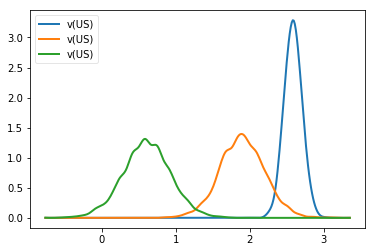

In [34]:
pilot_vUS = pilot_model.nodes_db.node['v(US)']
controls_vUS = controls_model.nodes_db.node['v(US)']
patients_vUS = patients_model.nodes_db.node['v(US)']

hddm.analyze.plot_posterior_nodes([pilot_vUS, controls_vUS, patients_vUS])

print("Drift Rate Analysis: US")
print('P(patients_vUS > controls_vUS) = ' + str((patients_vUS.trace() > controls_vUS.trace()).mean()))
print('P(controls_vUS > pilot_vUS) = ' + str((controls_vUS.trace() > pilot_vUS.trace()).mean()))

Drift Rate Analysis: CS
P(patients_vCS > controls_vCS) = 0.00670454545455
P(controls_vCS > pilot_vCS) = 0.00352272727273


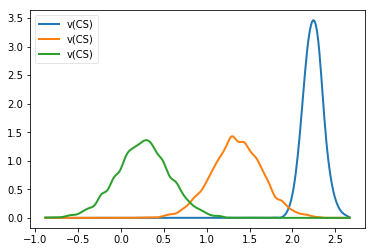

In [35]:
pilot_vCS = pilot_model.nodes_db.node['v(CS)']
controls_vCS = controls_model.nodes_db.node['v(CS)']
patients_vCS = patients_model.nodes_db.node['v(CS)']

hddm.analyze.plot_posterior_nodes([pilot_vCS, controls_vCS, patients_vCS])

print("Drift Rate Analysis: CS")
print('P(patients_vCS > controls_vCS) = ' + str((patients_vCS.trace() > controls_vCS.trace()).mean()))
print('P(controls_vCS > pilot_vCS) = ' + str((controls_vCS.trace() > pilot_vCS.trace()).mean()))

Drift Rate Analysis: CP
P(patients_vCP > controls_vCP) = 0.147954545455
P(controls_vCP > pilot_vCP) = 0.00181818181818


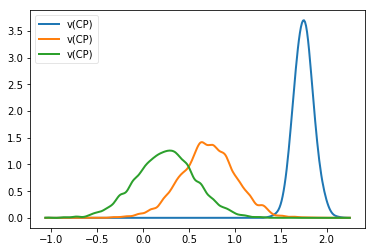

In [36]:
pilot_vCP = pilot_model.nodes_db.node['v(CP)']
controls_vCP = controls_model.nodes_db.node['v(CP)']
patients_vCP = patients_model.nodes_db.node['v(CP)']

hddm.analyze.plot_posterior_nodes([pilot_vCP, controls_vCP, patients_vCP])

print("Drift Rate Analysis: CP")
print('P(patients_vCP > controls_vCP) = ' + str((patients_vCP.trace() > controls_vCP.trace()).mean()))
print('P(controls_vCP > pilot_vCP) = ' + str((controls_vCP.trace() > pilot_vCP.trace()).mean()))

---

---

### Non-Decision Time Between Subjects

Non-Decision Time Analysis
P(patients_t > controls_t) = 0.126704545455
P(controls_t > pilot_t) = 0.909886363636


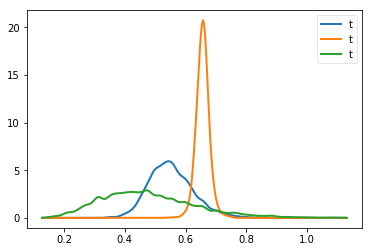

In [37]:
pilot_t = pilot_model.nodes_db.node['t']
controls_t = controls_model.nodes_db.node['t']
patients_t = patients_model.nodes_db.node['t']

hddm.analyze.plot_posterior_nodes([pilot_t, controls_t, patients_t])

print("Non-Decision Time Analysis")
print('P(patients_t > controls_t) = ' + str((patients_t.trace() > controls_t.trace()).mean()))
print('P(controls_t > pilot_t) = ' + str((controls_t.trace() > pilot_t.trace()).mean()))

---

---

### Bias Between Subjects

Bias Analysis
P(patients_z > controls_z) = 0.000227272727273
P(controls_z > pilot_z) = 0.996590909091


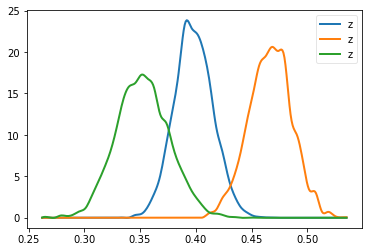

In [38]:
pilot_z = pilot_model.nodes_db.node['z']
controls_z = controls_model.nodes_db.node['z']
patients_z = patients_model.nodes_db.node['z']

hddm.analyze.plot_posterior_nodes([pilot_z, controls_z, patients_z])

print("Bias Analysis")
print('P(patients_z > controls_z) = ' + str((patients_z.trace() > controls_z.trace()).mean()))
print('P(controls_z > pilot_z) = ' + str((controls_z.trace() > pilot_z.trace()).mean()))

---  


---

### Threshold

#### Between Subjects

Tested from model where stimulus type does not affect threshold

Threshold Analysis: Between-Subjects
P(patients_a > controls_a) = 0.998522727273
P(controls_a > pilot_a) = 0.0260227272727


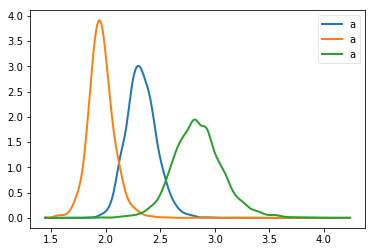

In [39]:
pilot_a = pilot_model.nodes_db.node['a']
controls_a = controls_model.nodes_db.node['a']
patients_a = patients_model.nodes_db.node['a']

hddm.analyze.plot_posterior_nodes([pilot_a, controls_a, patients_a])

print("Threshold Analysis: Between-Subjects")
print('P(patients_a > controls_a) = ' + str((patients_a.trace() > controls_a.trace()).mean()))
print('P(controls_a > pilot_a) = ' + str((controls_a.trace() > pilot_a.trace()).mean()))

---

### Model Deviance Information Criterion (DIC)

Measure of model fitness for hierarchical models, lower is better

In [40]:
# Pilot models
print("Stimulus Model DIC: " + str(pilot_model.dic))
print("Lumped Model DIC: " + str(pilot_model_lumped.dic))
#print("Stimulus+Threshold Model DIC: " + str(pilot_model_threshold.dic))

Stimulus Model DIC: 795.609087068
Lumped Model DIC: 1016.28785087


In [41]:
# Control models
print("Stimulus Model DIC: " + str(controls_model.dic))
print("Lumped Model DIC: " + str(controls_model_lumped.dic))
#print("Stimulus+Threshold Model DIC: " + str(controls_model_threshold.dic))

Stimulus Model DIC: 800.516022989
Lumped Model DIC: 869.320751214


In [42]:
# Patient models
print("Stimulus Model DIC: " + str(patients_model.dic))
print("Lumped Model DIC: " + str(patients_model_lumped.dic))
#print("Stimulus+Threshold Model DIC: " + str(patients_model_threshold.dic))

Stimulus Model DIC: 2619.7750154
Lumped Model DIC: 3222.23689013


-------